<a href="https://colab.research.google.com/github/Boshra-01/Rust-IR-BERT/blob/main/LLVM_IR_RustML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/snippet4/label4.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Requirement already satisfied: transformers in /usr/local/lib/python3.11/dist-packages (4.51.3)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/factory.py", line 169, in _make_candidate_from_dist
    base = self._installed_candidate_cache[dist.canonical_name]
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
KeyError: 'nvidia-cuda-runtime-cu12'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", 

Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embeddings shape: (1849, 768), vulnerable: 396, safe: 1453
Optimal threshold: 0.35 with F1 = 0.9873
Test Accuracy: 0.981081081081081
              precision    recall  f1-score   support

           0     0.9830    0.9931    0.9880       291
           1     0.9737    0.9367    0.9548        79

    accuracy                         0.9811       370
   macro avg     0.9783    0.9649    0.9714       370
weighted avg     0.9810    0.9811    0.9809       370



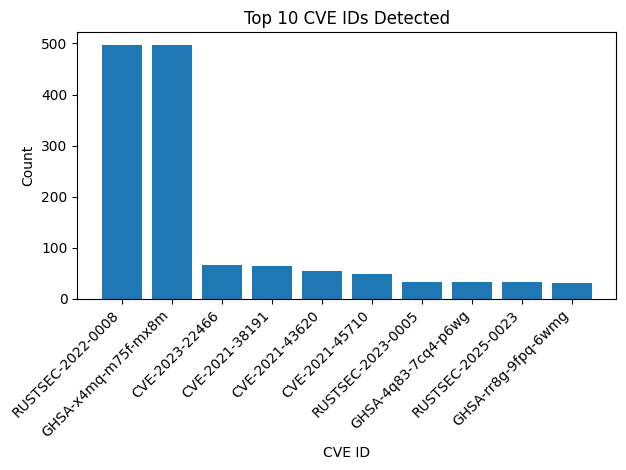

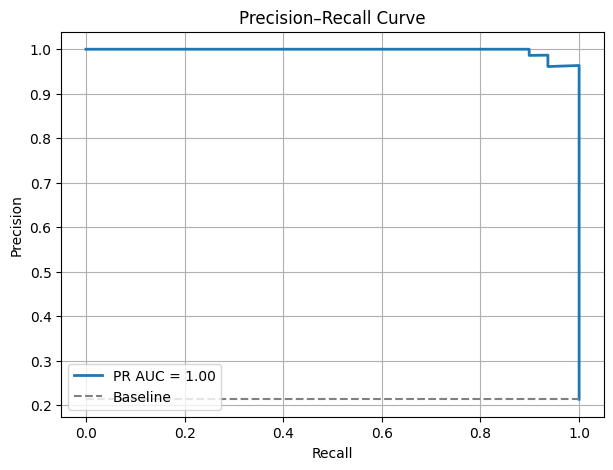

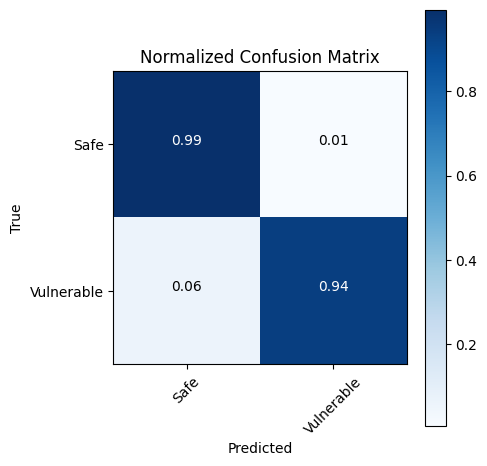

Upload a new .ll file for inference:


Saving kill.ll to kill.ll
**VULNERABLE**
Assigned CVE: RUSTSEC-2024-0007


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q "/content/drive/MyDrive/Colab Notebooks/Rust/snippet4.zip" -d /content/

!pip install transformers torch pandas scikit-learn catboost

import os, torch, pandas as pd, numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc, f1_score, confusion_matrix
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Loading & Normalizing Labels of CSV
csv_path = "/content/snippet4/label4.csv"
df = pd.read_csv(csv_path)
df['filename'] = df['ll_path'].str.replace('\\','/').apply(os.path.basename)
df['is_vuln']  = df['filename'].str.endswith("_v.ll").astype(int)
df['ll_fullpath'] = df['filename'].apply(
    lambda fn: os.path.join("/content/snippet4",
                            "vulnerable" if fn.endswith("_v.ll") else "non-vulnerable",
                            ".ll", fn)
)


def salvage(fn):
    for root, _, files in os.walk("/content/snippet4"):
        if fn in files:
            return os.path.join(root, fn)
    return None

df['exists'] = df['ll_fullpath'].apply(os.path.exists)
for idx, row in df[~df['exists']].iterrows():
    alt = salvage(row['filename'])
    if alt:
        df.at[idx, 'll_fullpath'] = alt
        df.at[idx, 'exists'] = True
df = df[df['exists']].reset_index(drop=True)

# Helper to Load & Clean LLVM IR code
def load_and_clean_ir(path):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        return "".join(line for line in f if not line.lstrip().startswith(';'))

# Initializing GraphCodeBERT
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
model     = AutoModel.from_pretrained("microsoft/graphcodebert-base").to(device)
model.eval()

# Extracting CLS Embeddings
embs, labs, cves = [], [], []
for _, row in df.iterrows():
    code = load_and_clean_ir(row['ll_fullpath'])
    if not code.strip():
        continue
    toks = tokenizer(code, return_tensors="pt", truncation=True, max_length=512)
    toks = {k: v.to(device) for k,v in toks.items()}
    with torch.no_grad():
        out = model(**toks)
    emb = out.last_hidden_state[0,0,:].cpu().numpy()
    embs.append(emb)
    labs.append(row['is_vuln'])
    cves.append(row.get('cve_id', ""))

X = np.vstack(embs)
y = np.array(labs)
print(f"Embeddings shape: {X.shape}, vulnerable: {y.sum()}, safe: {len(y)-y.sum()}")

# Train/Test/Validation

# 80/20 train-test, then 75/25 train-validation on the training split
X_tr, X_te, y_tr, y_te, cve_tr, cve_te = train_test_split(
    X, y, cves, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=42
)

# Feature Scaling
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_te_s    = scaler.transform(X_te)

# Training of CatBoost Classifier
clf = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)
clf.fit(X_train_s, y_train)

# Threshold Tuning on Validation
probs_val = clf.predict_proba(X_val_s)[:,1]
best_thresh, best_f1 = 0.5, 0.0
for t in np.linspace(0.1, 0.9, 81):
    preds = (probs_val >= t).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_thresh, best_f1 = t, f1
print(f"Optimal threshold: {best_thresh:.2f} with F1 = {best_f1:.4f}")

# Evaluation on Test Set
probs_te = clf.predict_proba(X_te_s)[:,1]
y_pred   = (probs_te >= best_thresh).astype(int)
print("Test Accuracy:", accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred, digits=4))

# Visualizations

# Top 10 CVEs
top_cves = df['cve_id'][df['cve_id']!=""].value_counts().nlargest(10)
plt.figure()
plt.bar(top_cves.index, top_cves.values)
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 CVE IDs Detected")
plt.xlabel("CVE ID"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_te, probs_te)
pr_auc = auc(recall, precision)
baseline = y_te.mean()
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}', linewidth=2)
plt.hlines(baseline, 0,1, linestyle='--', color='gray', label='Baseline')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curve'); plt.legend(); plt.grid(True); plt.show()

# Confusion Matrix
cm = confusion_matrix(y_te, y_pred)
cm_norm = cm.astype(float)/cm.sum(axis=1)[:,None]
plt.figure(figsize=(5,5))
plt.imshow(cm_norm, cmap='Blues', interpolation='nearest')
plt.title('Normalized Confusion Matrix'); plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ['Safe','Vulnerable'], rotation=45)
plt.yticks(ticks, ['Safe','Vulnerable'])
th = cm_norm.max()/2
for i in ticks:
    for j in ticks:
        plt.text(j, i, f"{cm_norm[i,j]:.2f}", ha='center',
                 color='white' if cm_norm[i,j]>th else 'black')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

# Inference on New .ll File
print("Upload a new .ll file for inference:")
up = files.upload()
if up:
    fname = next(iter(up))
    code = load_and_clean_ir(fname)
    toks = tokenizer(code, return_tensors="pt", truncation=True, max_length=512)
    toks = {k:v.to(device) for k, v in toks.items()}
    with torch.no_grad():
        out = model(**toks)
    new_emb = out.last_hidden_state[0,0,:].cpu().numpy().reshape(1, -1)
    new_emb_s = scaler.transform(new_emb)
    prob = clf.predict_proba(new_emb_s)[:,1][0]
    pred = int(prob >= best_thresh)
    print("**VULNERABLE**" if pred else "**NOT VULNERABLE**")
    if pred:
        # Assign CVE by nearest-centroid (precomputed or simple nearest neighbor)…
        vuln_embs = X_tr[y_tr==1]
        vuln_cves = np.array(cve_tr)[y_tr==1]
        dists = np.linalg.norm(vuln_embs - new_emb, axis=1)
        idx = int(np.argmin(dists))
        print("Assigned CVE:", vuln_cves[idx])


,Accuracy,Macro Precision,Macro Recall,Macro F1
LLVM IR Pipeline,0.981081,0.9783,0.9649,0.9714
Rust Pipeline,0.800000,0.7477,0.8498,0.7619


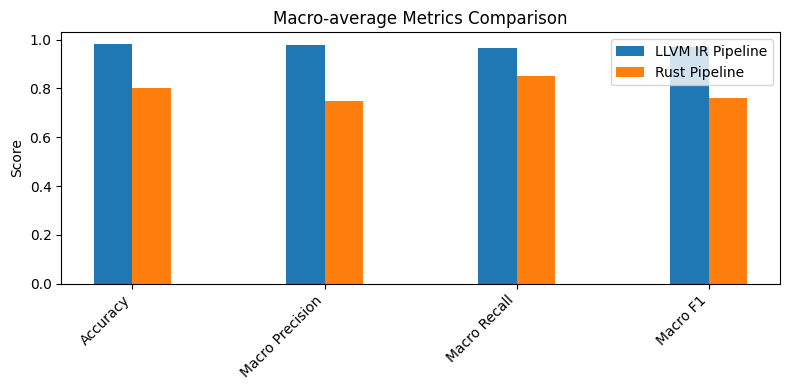

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = {
    'LLVM IR Pipeline': {
        'Accuracy': 0.981081081081081,
        'Macro Precision': 0.9783,
        'Macro Recall': 0.9649,
        'Macro F1': 0.9714
    },
    'Rust Pipeline': {
        'Accuracy': 0.8000,
        'Macro Precision': 0.7477,
        'Macro Recall': 0.8498,
        'Macro F1': 0.7619
    }
}

df = pd.DataFrame(data).T
# Display the DataFrame as a table
display(df)

# plotted grouped bar chart
metrics = df.columns.tolist()
x = np.arange(len(metrics))
width = 0.20

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - width/2, df.loc['LLVM IR Pipeline'], width, label='LLVM IR Pipeline')
ax.bar(x + width/2, df.loc['Rust Pipeline'], width, label='Rust Pipeline')

ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Macro‐average Metrics Comparison')
ax.legend()
plt.tight_layout()
plt.show()
